<a href="https://colab.research.google.com/github/dvignoles/sos/blob/master/SOS_Wavewatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate maps for Science on a Sphere using Cartopy : Wavewatch

This notebook outlines the process of creating maps formatted properly for the NOAA Science on a Sphere. The data used is from the [Wavewatch 3](https://polar.ncep.noaa.gov/waves/index.shtml?) ocean wave model.

## Daniel Vignoles August 2019
### NCEP Summer Internship

* dvignoles@gmail.com

## Python Environment

I used [Anaconda](https://www.anaconda.com/distribution/) to manage the python environment used in this project. Needed packages are listed in the imports below. As Anaconda in installed by default in your Home directory, no administator privileges are needed to install packages. If working on a restricted computer, this will save you *a lot* of time. If you end up needing to deploy a conda environment check out [conda-pack](https://conda.github.io/conda-pack/).

## Imports

In [0]:
#Interact with FTP servers
from ftplib import FTP

#Manipulate and extract Datetime information
from datetime import datetime

#Match patterns in strings (filenames and directories)
import re

#Extract data from .grib files 
import Nio

#Plotting/Mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Get data from NOAA FTP server
https://ftp.ncep.noaa.gov/data/nccf/com/wave/prod/

In [0]:
ftp = FTP("ftp.ncep.noaa.gov")
ftp.login()
ftp.cwd("pub/data/nccf/com/wave/prod")

'250 Directory successfully changed.'

In [0]:
data_dirs = ftp.nlst()
data_dirs

['glwu.20190731',
 'glwu.20190801',
 'glwu.20190802',
 'glwu.20190803',
 'glwu.20190804',
 'glwu.20190805',
 'glwu.20190806',
 'glwu.20190807',
 'gwes.20190731',
 'gwes.20190801',
 'gwes.20190802',
 'gwes.20190803',
 'gwes.20190804',
 'gwes.20190805',
 'gwes.20190806',
 'gwes.20190807',
 'multi_1.20190731',
 'multi_1.20190801',
 'multi_1.20190802',
 'multi_1.20190803',
 'multi_1.20190804',
 'multi_1.20190805',
 'multi_1.20190806',
 'multi_1.20190807',
 'nfcens.20190731',
 'nfcens.20190801',
 'nfcens.20190802',
 'nfcens.20190803',
 'nfcens.20190804',
 'nfcens.20190805',
 'nfcens.20190806',
 'nfcens.20190807']

### Let's look at the most recent "multi" folder

In [0]:
chosen_dir = data_dirs[23]
ftp.cwd(chosen_dir)

'250 Directory successfully changed.'

### Extract Datetime from directory name

In [0]:
#Match date string with regular expression
date_pattern = re.compile(r'\d{8}')
data_date_str = date_pattern.search(chosen_dir).group()
print(data_date_str)
                          
#convert to datetime object
data_datetime = datetime.strptime(data_date_str, "%Y%m%d")
data_datetime

20190807


datetime.datetime(2019, 8, 7, 0, 0)

### Filter out the files we're interested in

In [0]:
data_filenames = [file for file in ftp.nlst() if "glo_30mext" in file and ".idx" not in file]

In [0]:
#Filter out the t00z forecast
t00z_filenames = [file for file in data_filenames if 't00z' in file]
t00z_filenames[0:5]

['multi_1.glo_30mext.t00z.f000.grib2',
 'multi_1.glo_30mext.t00z.f003.grib2',
 'multi_1.glo_30mext.t00z.f006.grib2',
 'multi_1.glo_30mext.t00z.f009.grib2',
 'multi_1.glo_30mext.t00z.f012.grib2']

### Download a forecast 

In [0]:
chosen_file = t00z_filenames[0]

In [0]:
filedata = open(chosen_file, "wb")
print(ftp.retrbinary("RETR " + chosen_file, filedata.write))
filedata.close()

226 Transfer complete.


## Open the grib2 file

In [0]:
data = Nio.open_file(chosen_file,mode='r')

### What variables are available to us?

In [0]:
for key in data.variables.keys():
    print(key,data.variables[key].long_name)

WDIR_P0_L1_GLL0 Wind direction (from which blowing)
WIND_P0_L1_GLL0 Wind speed
UGRD_P0_L1_GLL0 U-component of wind
VGRD_P0_L1_GLL0 V-component of wind
HTSGW_P0_L1_GLL0 Significant height of combined wind waves and swell
WVDIR_P0_L1_GLL0 Direction of wind waves
WVHGT_P0_L1_GLL0 Significant height of wind waves
WVPER_P0_L1_GLL0 Mean period of wind waves
SWDIR_P0_L241_GLL0 Direction of Swell Waves
SWELL_P0_L241_GLL0 Significant height of swell waves
SWPER_P0_L241_GLL0 Mean period of swell waves
DIRPW_P0_L1_GLL0 Primary wave direction
PERPW_P0_L1_GLL0 Primary wave mean period
lv_OSEQD0 Ordered Sequence of Data
lat_0 latitude
lon_0 longitude


### Let's look at Significant Wave Height

In [0]:
lat = data.variables['lat_0']
lon = data.variables['lon_0']
swh = data.variables['SWELL_P0_L241_GLL0']

In [0]:
print(lat[:].shape)
print(lon[:].shape)
print(swh[0].shape)

(336,)
(720,)
(336, 720)


### Set up our canvas (Figure + Axes)

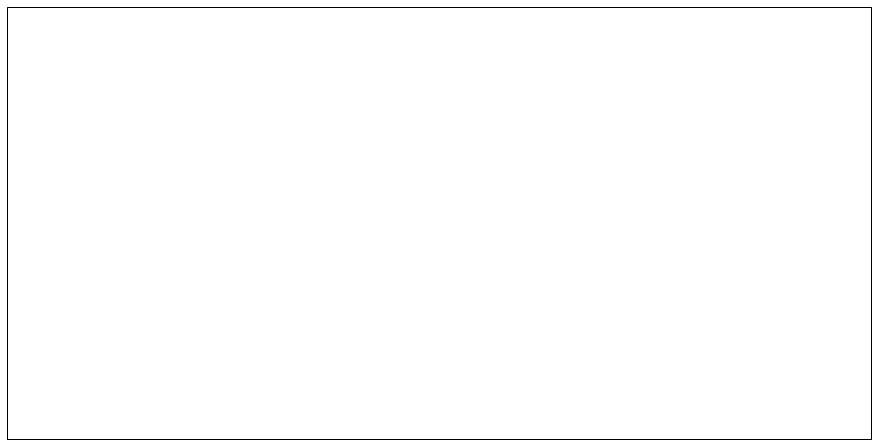

In [0]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

### Remove border and Background

In [0]:
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

### Add basemap

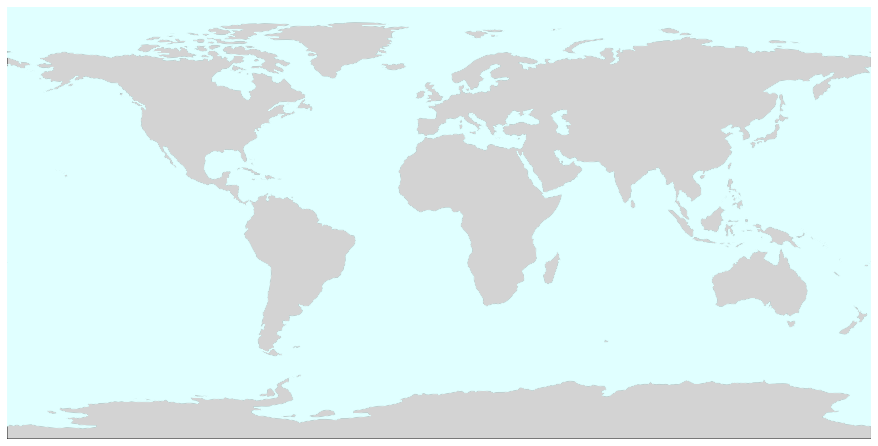

In [0]:
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="lightcyan")
fig

### Add data

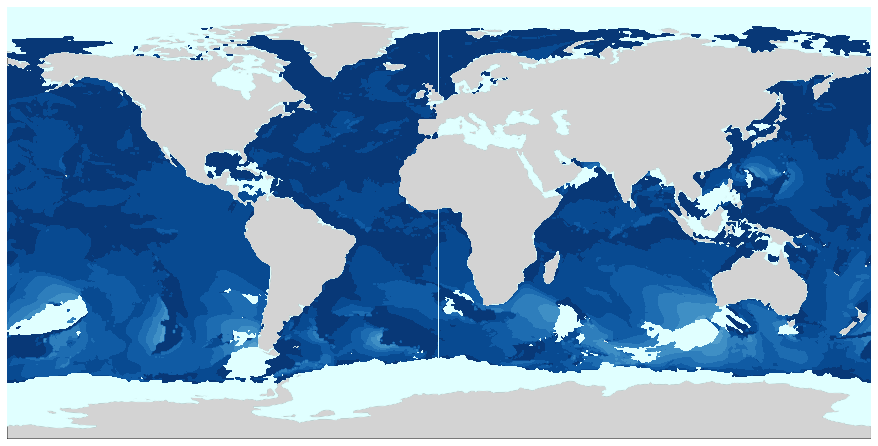

In [0]:
mappable = ax.contourf(lon[:], lat[:], swh[0], cmap='Blues_r', levels = list(range(0,16)),transform=ccrs.PlateCarree())
fig

### Save our Map
Multiply Width and Height by dpi to determine resolution.

4.096 * 1000 = 4096

2.048 * 1000 = 2048

Resolution: 4096x2048

In [0]:
fig.set_size_inches(4.096,2.048)
filename = 'swh_' + data_datetime.strftime('%Y-%m-%d') + '_t00z_' + 'f00' '.png'
fig.savefig(filename, dpi=1000)
print(filename)

swh_2019-08-07_t00z_f00.png


### Save colorbar

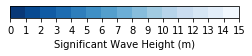

In [0]:
fig,ax = plt.subplots(figsize=(4.096,2.048))

cbar = plt.colorbar(mappable, orientation='horizontal',
                    extend='both', ticks=list(range(0,16)))

cbar.set_label('Significant Wave Height (m)')

ax.remove()
plt.savefig('swh_colorbar.png', dpi=250, bbox_inches='tight',
            pad_inches=0, transparent=True)